# Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
from numpy import load
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants
from scipy.linalg import expm

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

from tqdm.notebook import tqdm, trange

import itertools

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

## Defining parameters

In [2]:
MOLECULE_STRING = "Rb87Cs133"
MOLECULE = Rb87Cs133
N_MAX=2

B_MIN_GAUSS = 0.001 #G
B_MAX_GAUSS = 1000 #G
B_STEPS = 500

PULSE_TIME_US = 500 #μs

settings_string = f'{MOLECULE_STRING}NMax{N_MAX}BMin{B_MIN_GAUSS}BMax{B_MAX_GAUSS}BSteps{B_STEPS}PTime{PULSE_TIME_US}'

## Computed Constants

In [3]:
H_BAR = scipy.constants.hbar
muN = scipy.constants.physical_constants['nuclear magneton'][0]

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*I1)
I2_D = round(2*I2)

D_0 = MOLECULE["d0"]

PER_MN = round((2*I1+1)*(2*I2+1))
N_STATES = PER_MN * (N_MAX+1)**2

GAUSS = 1e-4 # T
B_MIN = B_MIN_GAUSS * GAUSS # T
B_MAX = B_MAX_GAUSS * GAUSS # T
PULSE_TIME = PULSE_TIME_US * 1e-6 # s

B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T 

# Load precomputed results

In [4]:
data = np.load(f'../precomputed/{settings_string}.npz')

ENERGIES = data['energies']
STATES = data['states']

LABELS_D=data['labels_d']
UNCOUPLED_LABELS_D=data['uncoupled_labels_d']

MAGNETIC_MOMENTS=data['magnetic_moments'] 

COUPLINGS_ZERO=data['couplings_zero']
COUPLINGS_MINUS=data['couplings_minus']
COUPLINGS_PLUS=data['couplings_plus']
COUPLINGS = COUPLINGS_ZERO+COUPLINGS_MINUS+COUPLINGS_PLUS
POLARISED_COUPLING = [COUPLINGS_ZERO,COUPLINGS_PLUS,COUPLINGS_MINUS]

UNPOLARISED_PAIR_FIDELITIES = data['unpolarised_pair_fidelities_ut']
UNPOLARISED_PAIR_FIDELITIES = UNPOLARISED_PAIR_FIDELITIES + UNPOLARISED_PAIR_FIDELITIES.transpose(1,0,2)
POLARISED_PAIR_FIDELITIES = data['polarised_pair_fidelities_ut']
POLARISED_PAIR_FIDELITIES = POLARISED_PAIR_FIDELITIES + POLARISED_PAIR_FIDELITIES.transpose(1,0,2)

# Helper Functions

In [5]:
def label_to_state_no(N,MF_D,k):
    return np.where((LABELS_D[:, 0] == N) & (LABELS_D[:, 1] == MF_D) & (LABELS_D[:, 2] == k))[0][0]

def state_no_to_uncoupled_label(state_no):
    return UNCOUPLED_LABELS_D[state_no]

In [6]:
def label_d_to_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return f"({n},{mf_d//2},{i})"
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return f"({n},{mf_whole}.5,{i})"

def label_d_to_latex_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return r'|{},{}\rangle_{{{}}}'.format(n,mf_d//2,i)
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return r'|{},{}.5\rangle_{{{}}}'.format(n,mf_whole,i)

In [7]:
def label_degeneracy(N,MF_D):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    for MN in range(-N,N+1):
        for M_I1_D in range(-I1_D,I1_D+1,2):
            for M_I2_D in range(-I2_D,I2_D+1,2):
                if 2*MN+M_I1_D+M_I2_D == MF_D:
                    d+=1
    return d

In [8]:
def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def maximum_fidelity(k,g):
    phi = np.arccos((k*(18-9*g**2-8*k**2))/(3+3*g**2+4*k**2)**(3/2))/3
    denominator = 54*((1+g**2)**3+(-8+20*g**2+g**4)*k**2+16*k**4)
    numerator = (
                 36*(g**4+(1-4*k**2)**2+2*g**2*(1+8*k**2))
               + 32*k    *(3+3*g**2+4*k**2)**(3/2) *np.cos(phi)
               - 64*k**2 *(3+3*g**2+4*k**2)        *np.cos(2*phi) 
               -  4      *(3+3*g**2+4*k**2)**2     *np.cos(4*phi)
                )
    return numerator/denominator

def fidelity(ts,d=8):
    return -np.log10(1-ts+10**(-d))

# Simulator

In [65]:
# Driven couplings between states
chosen_states_coupling_labels = np.array([(0,8,1),(1,8,5)])
chosen_coupling_labels = [
    (chosen_states_coupling_labels[0],chosen_states_coupling_labels[1]),
    # (chosen_states_coupling_labels[1],chosen_states_coupling_labels[2]),
    # (chosen_states_coupling_labels[3],chosen_states_coupling_labels[2]),
    # (chosen_states_coupling_labels[0],chosen_states_coupling_labels[3]),
]

# With what desired rabi period
global_pulse_time = 500 * 1e-6 #s
chosen_pulse_time = [global_pulse_time]*4

# At what magnetic field
chosen_bi = round(B_STEPS*(44.0891/B_MAX_GAUSS))

# Only simulate other states that have strong off resonant coupling
cutoff = 0.9999999 # =0 for only these =1 for all states
        
# Simulation resolution
T_STEPS =  [803989,314927,195931,65519,41443,21319,9391,50][0] 

# Simulation time length (how many Rabi periods to show)
TIME = chosen_pulse_time[0]*4

In [66]:
# Compute further constants and indices from molecular parameters
if cutoff == 0:
    chosen_states_labels = chosen_states_coupling_labels
elif cutoff == 1:
    chosen_states_labels = LABELS_D
else:
    needed_states = np.full(N_STATES, False)
    for (al,bl),pt in zip(chosen_coupling_labels, chosen_pulse_time):
        ai = label_to_state_no(*al)
        bi = label_to_state_no(*bl)
        ks_up = np.abs((ENERGIES[chosen_bi, :] - ENERGIES[chosen_bi, bi, None]) * pt / scipy.constants.h)
        ks_down = np.abs((ENERGIES[chosen_bi, :] - ENERGIES[chosen_bi, ai, None]) * pt / scipy.constants.h)

        gs_unpolarised_up = np.abs(COUPLINGS[chosen_bi, ai, :]/COUPLINGS[chosen_bi, ai, bi])
        gs_unpolarised_down = np.abs(COUPLINGS[chosen_bi, bi, :]/COUPLINGS[chosen_bi, ai, bi])

        fidelities_unpolarised_up = twice_average_fidelity(ks_up,gs_unpolarised_up)
        fidelities_unpolarised_down = twice_average_fidelity(ks_down,gs_unpolarised_down)
        
        needed_states = needed_states + (fidelities_unpolarised_up < cutoff) + (fidelities_unpolarised_down < cutoff)
        chosen_states_labels = LABELS_D[needed_states]
    print(f"These states passed the cutoff ({cutoff}):")
    print(chosen_states_labels)
    
chosen_states_coupling_subindices = [np.where((chosen_states_labels[:, 0] == N) & (chosen_states_labels[:, 1] == MF) & (chosen_states_labels[:, 2] == k))[0][0] for N,MF,k in chosen_states_coupling_labels]
chosen_states_indices = np.array([label_to_state_no(*label) for label in chosen_states_labels])
chosen_number_of_states = len(chosen_states_indices)

These states passed the cutoff (0.9999999):
[[ 0  6  0]
 [ 0  8  0]
 [ 0  6  1]
 [ 0 10  0]
 [ 0  8  1]
 [ 0  6  2]
 [ 1  8  0]
 [ 1  6  1]
 [ 1 10  0]
 [ 1  8  1]
 [ 1  6  2]
 [ 1  8  2]
 [ 1  6  4]
 [ 1 10  1]
 [ 1  8  3]
 [ 1  6  5]
 [ 1 10  2]
 [ 1  8  4]
 [ 1  6  6]
 [ 1  6  7]
 [ 1  8  5]
 [ 1  6  8]]


In [67]:
# Get Angular Frequency Matrix Diagonal for each B
all_angular = ENERGIES[chosen_bi, :].real / H_BAR # [state]
angular = all_angular[chosen_states_indices]

all_couplings = COUPLINGS[chosen_bi]
couplings = all_couplings[:,chosen_states_indices][chosen_states_indices,:]

# Get driving frequencies & polarisations
driving = []
E_i = []
for (l1,l2), pulse_time in zip(chosen_coupling_labels, chosen_pulse_time):
    i1=label_to_state_no(*l1)
    i2=label_to_state_no(*l2)
    driving.append(np.abs(all_angular[i1]-all_angular[i2]))
    E_i.append((2*np.pi*H_BAR) / (D_0 * all_couplings[i1,i2] * pulse_time))
driving = np.array(driving)
print("Driving (rad/s):", driving)
E_i = np.array(E_i,dtype=np.double)
print("E (V/m):", E_i)

# Construct times
times, DT = np.linspace(0,TIME,num=T_STEPS,retstep=True)

# Construct kinetic time step operator (Matrix Diagonal)
T_OP_DIAG = np.exp(-(1j) * angular * DT/2 )

# Construct potential fixed part time step operator 
ORDER = 10
V_TI_M = (-(1j)*D_0*couplings*DT)/H_BAR
V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)])

# Construct state vector
state_vector = np.zeros((T_STEPS,chosen_number_of_states), dtype=np.cdouble)
state_vector[0,chosen_states_coupling_subindices[0]] = np.sqrt(1)
state_vector[0,chosen_states_coupling_subindices[0]] = np.sqrt(1)

for t_num in trange(T_STEPS-1):
    pres = E_i*np.cos(driving*times[t_num])
    V_TD_POWS = np.sum(pres)**(np.arange(ORDER))
    V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[:,None,None],axis=0)
    
    DU = T_OP_DIAG[:,None] * V_OP[:,:] * T_OP_DIAG[None,:]
    state_vector[t_num+1] = DU @ state_vector[t_num]

resolution=20
probabilities = np.abs(state_vector[::resolution,:])**2

Driving (rad/s): [6.161e+09]
E (V/m): [1.238e+00]


/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_73201/2530732540.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  E_i = np.array(E_i,dtype=np.double)


  0%|          | 0/803988 [00:00<?, ?it/s]

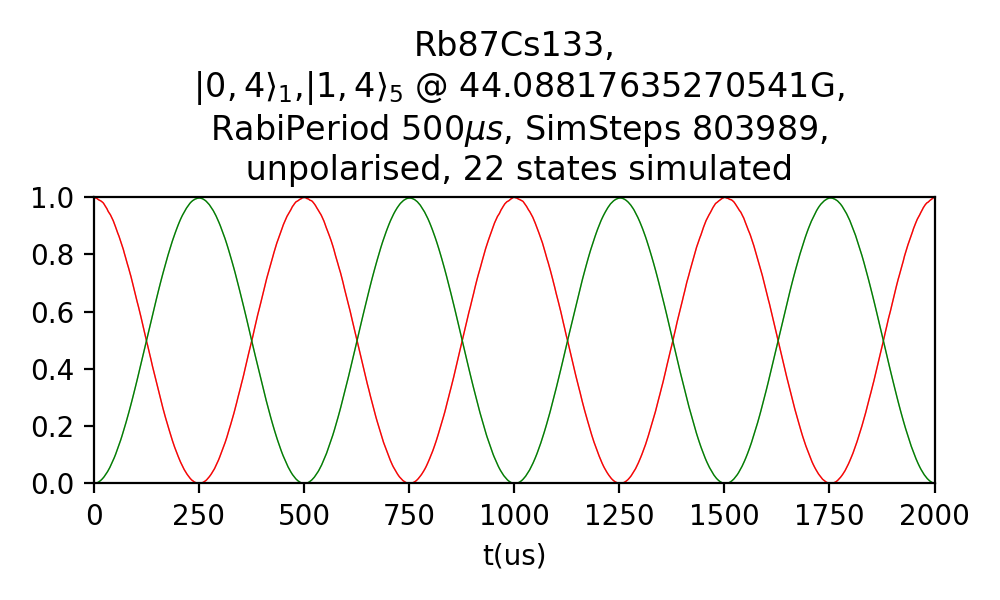

In [64]:
# Plot results
fig,ax = plt.subplots(figsize=(5,3))
ax.set_xlabel('t(us)')
ax.set_ylim(0,1.0)
ax.set_xlim(0,TIME*1e6)
states_string = ','.join([f'${label_d_to_latex_string(label)}$' for label in chosen_states_coupling_labels])
ax.set_title('{},\n {} @ {}G,\n RabiPeriod {}$\mu s$, SimSteps {},\n unpolarised, {} states simulated'
             .format(MOLECULE_STRING,
                     states_string,
                     B_MAX_GAUSS*chosen_bi/(B_STEPS-1),
                     round(global_pulse_time*1e6),
                     T_STEPS,
                     chosen_number_of_states))

c = ['red','green','blue','purple']
ax.plot(times[::resolution]*1e6,probabilities[:,:],c='grey',linewidth=0.5,alpha=0.5);
for i,state_subindex in enumerate(chosen_states_coupling_subindices):
    ax.plot(times[::resolution]*1e6,probabilities[:,state_subindex],c=c[i],linewidth=0.5);
    
fig.savefig(f'../images/{MOLECULE_STRING}-2-state-qubit-sim-a.pdf')